In [14]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
# import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create pairs (first track, subsequent track, time)

In [16]:
data = pd.concat([
    pd.read_json("./../logs/contextual/log/data.json", lines=True),
    pd.read_json("./../logs/contextual/log/data.json.1", lines=True),
    pd.read_json("./../logs/contextual/log/data.json.2", lines=True),
    pd.read_json("./../logs/contextual/log/data.json.3", lines=True)
])

In [17]:
# data = data[(data["message"] == "last") | (data["time"] > 0.1)]

In [18]:
data.shape

(1850498, 8)

In [19]:
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments
0,next,2023-04-13 13:12:50.235,2865,33269,0.0,0.000884,672.0,{'AA': 'T1'}
1,next,2023-04-13 13:12:50.239,1137,177,0.0,0.000845,178.0,{'AA': 'T1'}
2,next,2023-04-13 13:12:50.241,7145,424,1.0,0.001173,171.0,{'AA': 'C'}
3,next,2023-04-13 13:12:50.243,7414,36573,0.0,0.001659,5615.0,{'AA': 'C'}
4,next,2023-04-13 13:12:50.245,2865,672,0.0,0.000709,6464.0,{'AA': 'T1'}


In [39]:
data["user"].value_counts()

user
601     567
838     531
5219    525
2186    502
810     492
       ... 
4161     55
6578     54
4789     50
5907     45
9205     45
Name: count, Length: 10000, dtype: int64

In [21]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))
        
        if row["message"] == "last":
            first = None
    return pairs

In [22]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

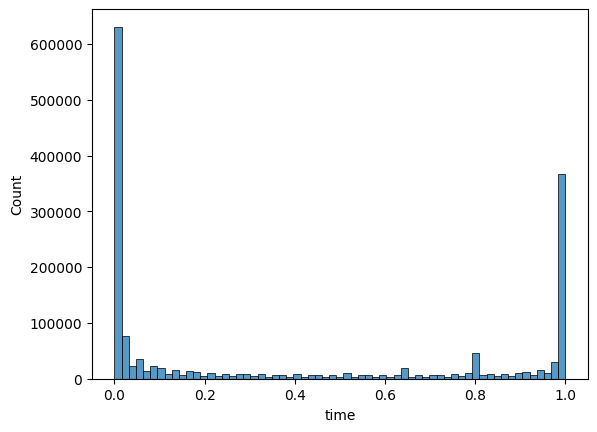

In [24]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax);

## Train Model

In [25]:
pairs["time"] = pairs["time"].astype("float32")

In [26]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(1320308, 164209, 165482)

In [28]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, embedding_dim=100):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        self.context = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
#         self.best_track = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)

    def forward(self, x):
        context = self.context(x[:, 0]) # start track
        track = self.track(x[:, 1]) # next track
#         best_track = self.track(x[:, 2]) # best track
        return torch.sum(context * track, dim=1)
            
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [29]:
class ContextualRankerData(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, features):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.features = features

    def prepare_data(self):
        self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data)).astype("float32")).assign(avg = self.train_data["time"].mean())

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = td.TensorDataset(
                torch.from_numpy(self.train_data[self.features].values), 
                torch.from_numpy(self.train_data["time"].values)
            )

            self.val_dataset = td.TensorDataset(
                torch.from_numpy(self.val_data[self.features].values), 
                torch.from_numpy(self.val_data["time"].values)
            )

        if stage == "test" or stage is None:  
            self.test_dataset = td.TensorDataset(
                torch.from_numpy(self.test_data[self.features].values),
                torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
            )
            
    def train_dataloader(self):
        return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

    def val_dataloader(self):
        return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

    def test_dataloader(self):
        return td.DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=0)

In [30]:
net = ContextualRanker(embedding_dim=100)
data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track"])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=500,
    accelerator='mps', 
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [31]:
trainer.fit(
    net, 
    data_module
)


  | Name    | Type      | Params
--------------------------------------
0 | context | Embedding | 5.0 M 
1 | track   | Embedding | 5.0 M 
--------------------------------------
10.0 M    Trainable params
0         Non-trainable params
10.0 M    Total params
40.000    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/administrator/opt/miniconda3/envs/kaggle/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/administrator/opt/miniconda3/envs/kaggle/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00051: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00057: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [32]:
best = ContextualRanker.load_from_checkpoint(checkpoint_callback.best_model_path, embedding_dim=100)

In [33]:
trainer.test(best, data_module)

/Users/administrator/opt/miniconda3/envs/kaggle/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        avg_loss            0.18635199964046478
        rdm_loss            0.28119799494743347
        test_loss           0.1298910230398178
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.1298910230398178,
  'avg_loss': 0.18635199964046478,
  'rdm_loss': 0.28119799494743347}]

## Compute top recommendations

In [34]:
track_meta = pd.read_json("./../botify/data/tracks.json", lines=True)

In [35]:
context_embeddings = dict(best.named_parameters())["context.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()

In [36]:
track_meta.head()

,artist,title,track
0,Jack Johnson,The Cove,0
1,Billy Preston,Nothing from Nothing,1
2,Paco De Lucia,Entre Dos Aguas,2
3,Josh Rouse,Under Cold Blue Stars,3
4,The Dead 60s,Riot Radio (Soundtrack Version),4


In [44]:
k = 100
with open("./../botify/data/homework_tracks_with_recs_v7.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        embedding = context_embeddings[track["track"]]
        neighbours = np.argpartition(-np.dot(track_embeddings, embedding), k)[:k]
        
        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.tolist()
        
        rf.write(json.dumps(recommendation) + "\n")

50000it [01:16, 656.05it/s]


In [100]:
users_preferences = pd.DataFrame(data[data["time"] > 0.2].groupby(["user"]).apply(lambda x: sorted(set(x["track"]))), columns=["preferences"]).reset_index()

In [101]:
users_preferences

,user,preferences
0,0,"[178, 422, 1305, 1541, 2252, 2659, 4023, 6022,..."
1,1,"[17, 129, 156, 157, 159, 162, 163, 170, 175, 1..."
2,2,"[129, 155, 156, 157, 159, 163, 171, 175, 176, ..."
3,3,"[140, 154, 156, 159, 162, 170, 176, 179, 181, ..."
4,4,"[122, 300, 409, 1081, 1165, 1253, 1265, 1361, ..."
...,...,...
9995,9995,"[140, 152, 156, 157, 162, 163, 170, 176, 178, ..."
9996,9996,"[17, 152, 156, 159, 162, 163, 170, 175, 176, 1..."
9997,9997,"[17, 170, 176, 299, 300, 302, 309, 313, 316, 3..."
9998,9998,"[152, 156, 157, 159, 163, 171, 175, 179, 200, ..."


In [102]:
users_preferences["preferences"].apply(len).agg(["min", "max"])

min      8
max    230
Name: preferences, dtype: int64

In [103]:
with open("./../botify/data/users_preferences.json", "w") as rf:
    for _, user_preferences in tqdm.tqdm(users_preferences.iterrows()):
        rf.write(json.dumps(dict(user_preferences)) + "\n")

10000it [00:00, 32759.61it/s]
